# Chapter 25 - Phase Response Curves
Phase response curves display the phase shift of a regularly spiking neuron as a function of the phase of a brief input pulse.
In this notebook, we will use NEURON to display the PRC of an RTM neuron.

In [1]:
from neuron import h
import os
import matplotlib.pyplot as plt

#First compile our modfiles.
if os.system('nrnivmodl modfiles') == 0:
    print("Compilation Succeeded.")
else:
    print("Compilation Failed.")

Compilation Succeeded.


In [2]:
#Include Neuron.
from neuron import h
h.load_file('stdrun.hoc')

#Define simumulation parameters.
SIMRUNTIME = 500
DELAY      = 0
INJTIME    = 500
I_INJ      = 0.00001

h.tstop    = SIMRUNTIME
h.v_init   = -66.345

#Define Cell Morphology.
soma = h.Section(name = 'soma')

soma.nseg = 1
soma.L    = 1.492
soma.diam = 1


#Define the biophysical parameters.
soma.cm = 1

#Insert channels into all sections.
soma.insert('leak')
soma.insert('k_rtm')
soma.insert('na_rtm')

#cell conductances and channel reversal potentials
soma.gbar_leak = .1e-3  #S/cm^2
soma.gbar_na_rtm = .1   #S/cm^2
soma.gbar_k_rtm = .08   #S/cm^2

soma.eleak = -67 #mV
soma.ena = 50    #mV
soma.ek = -100   #mV

i_inj = h.IClamp(soma(0.5))
i_inj.amp   = I_INJ
i_inj.dur   = INJTIME
i_inj.delay = DELAY

# Define synaptic parameters
syn = h.Exp2Syn(soma(0.5))

syn.tau1 = 0.5  # ms rise time
syn.tau2 = 2   # ms decay time
syn.e = 0       # mV reversal potential

## Run a baseline test to capture the firing rate of an RTM neuron under a current clamp (no input pulse).

In [3]:
potential = h.Vector()
time      = h.Vector()

time.record(h._ref_t) 
potential.record(soma(0.5)._ref_v)

netcon = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
vec = h.Vector()
netcon.record(vec)



#Run the experiment.
h.run()

timeNOinput=time.to_python()
potentialNOinput=potential.to_python()

spikesNOinput=vec.to_python()

h.finitialize()

period = spikesNOinput[3] - spikesNOinput[2]

[28.02500000009894, 85.90000000011096, 143.80000000010614, 201.6750000000535, 259.57500000000084, 317.4499999999482, 375.34999999989554, 433.2249999998429, 491.12499999979025]


### Create 200 input times between 143 ms and 201 ms (spikes 3 and 4)

In [4]:
X=list(range(200))
intime = [(x*period/200)+spikesNOinput[2] for x in X]
# Keep track of the phase of this input pulse on a scale from 0 to 1 (This is half of the PRC)
inphase= [(i-spikesNOinput[2])/period for i in intime]

We now iterate through 200 simulations where the input pulse time is set in the cell above. We record the spike times of each simulation

In [5]:
def runSim():
    spikes=[]    #spike times for individual trial
    data=[]      #List of all spikes[] lists
    for i in range(200):
        
        # Define the input spike.

        ns = h.NetStim()

        ns.interval=1000     #ms (mean) time between spikes
        ns.number=1      #(average) number of spikes
        ns.start=intime[i] #ms (most likely) start time of first spike
        ns.noise=0 # range 0 to 1. Fractional randomness.


        nc = h.NetCon(ns, syn)
        nc.threshold = 10 #mV
        nc.delay = 0 #ms
        nc.weight[0] = 0.000001
        
        
        #Set up spike times recording
        netcon = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
        vec = h.Vector()
        netcon.record(vec)
    
        # Run the simulation
        h.run()
    
        # Transfer NEURON recording vector to python list
        spikes=vec.to_python()
        data.append(spikes)
        
        # Restart each
        h.finitialize()

    return data

data= runSim()

Calculation of the phase change between the simulations of cells with input pulse and the sumulation of the neuron without input pulse.

In [8]:
timedif = []
outphase = []
for x in range(200):
    timedif.append(spikesNOinput[5]-data[x][5])
    outphase.append(timedif[x]/period)


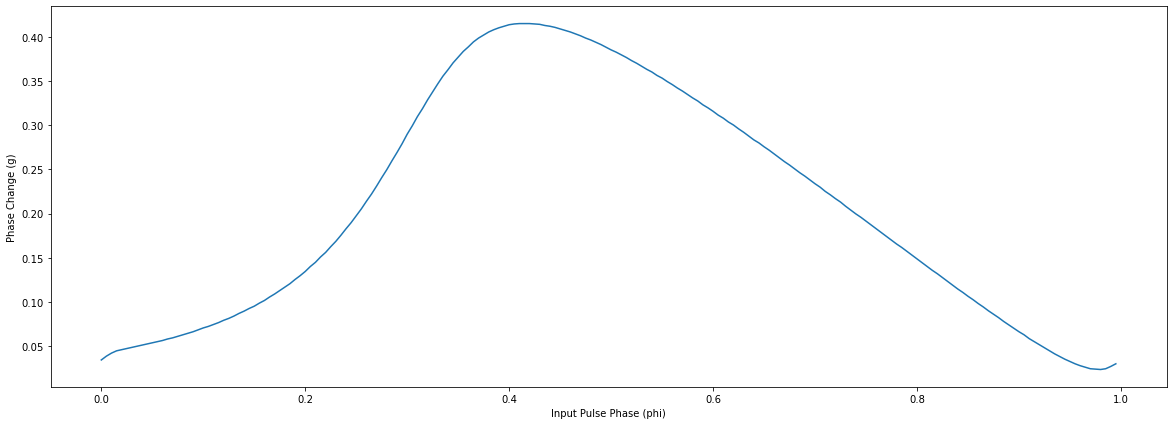

In [7]:
#Plot membrane potential.
def plot_membrane():
    plt.close()
    plt.figure(figsize = (20,7))
    plt.plot(inphase, outphase)
    plt.xlabel('Input Pulse Phase (phi)')
    plt.ylabel('Phase Change (g)')
    plt.show()
    
plot_membrane()

We can see that the timing of the input pulse affects how far forward or back the spiking of the RTM neuron will shift. In the case of the RTM neuron, an input pulse happening right between two spikes will cause the neuron to spike much sooner (positive phase change means leading original pattern).